## 0. Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import re
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from sklearn.feature_extraction.text import TfidfTransformer
from keras.preprocessing.text import text_to_word_sequence
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score

## 1. Prepare data

In [2]:
import sys
sys.path.insert(0, '/content/drive/MyDrive/ML/preprocessing')
import Preprocessor

In [3]:
X_train, y_train, X_test, y_test = Preprocessor.file_read_vectorizer('/content/drive/MyDrive/ML/data/TrainingSet.csv', '/content/drive/MyDrive/ML/data/TestSet.csv')

## 2. Model training

### 2.1. Individual model performances

In [4]:
# import model libraries
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

In [6]:
rf = RandomForestClassifier(n_estimators=100, criterion='entropy')
lr = LogisticRegression(C=100, max_iter=10000)
nb = MultinomialNB()

# SVM is time-intensive if we want to extract the output as probabilities, 
# thus not included in the base classifiers of Voting Classifier

for clf in (rf, lr, nb):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

RandomForestClassifier 0.8644
LogisticRegression 0.9017
MultinomialNB 0.8871


### 2.2. Voting classifier

In [8]:
rf = RandomForestClassifier(n_estimators=250, criterion='entropy')
lr = LogisticRegression(C=100, max_iter=10000)
nb = MultinomialNB()

voting_clf = VotingClassifier(
    estimators=[('lr', lr), ('rf', rf), ('nb', nb)],
    voting='soft')
voting_clf.fit(X_train, y_train)
print(voting_clf.__class__.__name__, accuracy_score(y_test, voting_clf.predict(X_test)))

VotingClassifier 0.9045


### 2.3. Model evaluation

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


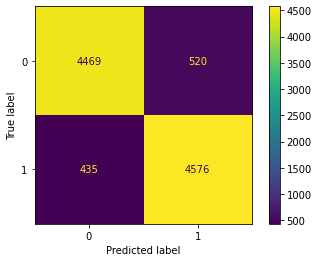

In [9]:
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix

plot_confusion_matrix(voting_clf, X_test, y_test)  
plt.show()